In [56]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import Union, List
import math
import pylab

# pyaldata
sys.path.append("/home/zms24/Desktop") 
import PyalData.pyaldata as pyal # type:ignore

# tools functions
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from tools.curbd import curbd
from tools.dsp.preprocessing import preprocess
from tools.rnn_and_curbd import rnn as rnnz
from tools.rnn_and_curbd import plotting as pltz
from tools.rnn_and_curbd import model_analysis as analyz
from tools.rnn_and_curbd import curbd as curbdz

# Reload modules
importlib.reload(rnnz)
importlib.reload(pltz)
importlib.reload(analyz)
importlib.reload(curbdz)

np.random.seed(44)

## Import RNN model and orginal df

In [45]:
filename = 'rnn_model_M044_2024_12_04_09_30.mat'
path = os.path.join("/home/zms24/Desktop/rnn_models/", filename)

data = loadmat(path, simplify_cells=True)  # works in SciPy >= 1.7
rnn_model = data['rnn_model']

In [46]:
def process_pyal_files(pyal_files: Union[str, List[str]], rnn_model, root_dir: str = "/data/raw") -> dict:
    if isinstance(pyal_files, str):
        pyal_files = [pyal_files]

    dfs = []
    for pyal_file in pyal_files:
        # Extract subject ID and session ID
        subject_id = pyal_file.split("_")[0]
        session_id = "_".join(pyal_file.split("_")[1:-1])  # everything between subject and 'pyaldata.mat'
        
        # Construct full path: /data/raw/<subject>/<session>/<file>
        data_dir = os.path.join(root_dir, subject_id, f"{subject_id}_{session_id}")
        fname = os.path.join(data_dir, pyal_file)

        df = pyal.mat2dataframe(fname, shift_idx_fields=True)
        dfs.append(df)

    # Combine and preprocess - custom for M044 session
    df = pd.concat(dfs, ignore_index=True)
    df_ = preprocess(df, only_trials=True)
    areas = ["M1_rates", "Dls_rates"]
    df_["M1_rates"] = [df_["all_rates"][i][:,300:] for i in range(len(df_))]
    df_["Dls_rates"] = [df_["all_rates"][i][:,0:300] for i in range(len(df_))]

    # Metadata
    areas = [col for col in df_.columns if col.endswith("_rates") and col != "all_rates"]
    # perturbation time
    perturbation_time = df_.idx_sol_on[0]
    perturbation_time_sec = df_.idx_sol_on[0] * df_['bin_size'][0]
    # solenoids
    sol_angles = df_.values_Sol_direction.unique()
    sol_angles.sort()
    trial_labels = [f"solenoid {angle}" for angle in sol_angles]
    trial_avg_rates = rnnz.average_by_trial(df_, sol_angles)
    shapes = [arr.shape[0] for arr in trial_avg_rates]

    # do trial avg
    trial_avg_rates = rnnz.average_by_trial(df_, sol_angles)
    concat_rates = np.concatenate(trial_avg_rates, axis=0)
    trial_avg_activity = np.transpose(concat_rates)
    reset_points = rnnz.get_reset_points(df_, trial_avg_activity, areas, rnn_model['params']['dtFactor'])
    regions_arr = rnnz.get_regions(df_, areas)

    return {
        'df_': df_,
        'sol_angles': sol_angles,
        'trial_labels': trial_labels,
        'trial_avg_rates': trial_avg_rates,
        'shapes': shapes,
        'areas': areas,
        'concat_rates': concat_rates,
        'reset_points': reset_points,
        'regions_arr': regions_arr,
        'perturbation_time': perturbation_time,
        'perturbation_time_sec': perturbation_time_sec
    }

In [47]:
pyal_dict = process_pyal_files("M044_2024_12_04_09_30_pyaldata.mat", rnn_model)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.


/home/zms24/Desktop/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_spikes ephys data shape is (NxT): (474, 133)
Trial length: 133


#### Metadata

In [48]:
BIN_SIZE =  rnn_model['dtData']
mouse = filename.split('_')[2]
shapes = pyal_dict['shapes']
trial_labels = pyal_dict['trial_labels']
regions_arr = pyal_dict['regions_arr']
areas = pyal_dict['areas']

## CURBD

In [49]:
brain_area_colors = {'MOp': "#3681D2", 'SSp': "#ff9d4d", 'CP': "#8ed74d", 'VAL': '#e76f51', 'all': '#bbbbbb'}
curbd_colors = {'M1 to M1': "#3681D2", 'M1 to Dls': "#36D2D2", 'Dls to Dls': "#8ed74d", 'Dls to M1': "#4dd7a2"}

In [50]:
curbd_arr, curbd_labels = curbd.computeCURBD(rnn_model)
n_regions = curbd_arr.shape[0]
currents, current_labels = curbdz.format_curbd_output(curbd_arr, curbd_labels, n_regions, pyal_dict['reset_points'])


In [51]:
print(current_labels )

['M1 to M1' 'Dls to M1' 'M1 to Dls' 'Dls to Dls']


In [52]:
def plot_currents_by_region(all_currents, all_currents_labels, perturbation_time, curbd_colours, bin_size, dtFactor, mouse_num):
    fig = pylab.figure(figsize=[10, 8])
    count = 1
    n_regions = int(math.sqrt(len(all_currents)))
    colours = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

    global_min, global_max = float('inf'), float('-inf')

    # First pass: find global y-limits
    mean_sem_data = []
    for i in range(len(all_currents)):
        current_data = np.array(all_currents[i])
        mean_current = np.mean(current_data, axis=(0, 1))
        sem_current = np.std(current_data, axis=(0, 1)) / np.sqrt(current_data.shape[0] * current_data.shape[1])

        y_lower = np.min(mean_current - sem_current)
        y_upper = np.max(mean_current + sem_current)

        global_min = min(global_min, y_lower)
        global_max = max(global_max, y_upper)

        mean_sem_data.append((mean_current, sem_current))

    # Second pass: plot with shared y-axis
    for i in range(len(all_currents)):
        current_label = all_currents_labels[i]
        colour = curbd_colours.get(current_label, colours[i % len(colours)])

        axn = fig.add_subplot(n_regions, n_regions, count)
        count += 1

        current_data = np.array(all_currents[i])
        time_axis = np.linspace(0, (current_data.shape[2] * bin_size)/dtFactor, current_data.shape[2])

        mean_current, sem_current = mean_sem_data[i]

        axn.plot(time_axis, mean_current, linewidth=2, color=colour)
        axn.fill_between(time_axis, mean_current - sem_current, mean_current + sem_current, alpha=0.3, color=colour)
        axn.axvline(perturbation_time, color='red', linestyle='--', linewidth=1, label='Perturbation time')

        axn.set_title(f'{current_label} mean current', fontsize='xx-large')
        axn.set_xlabel('Time (s)', fontsize='xx-large')
        axn.set_ylabel('Current Strength', fontsize='xx-large')

        axn.set_ylim(global_min, global_max)

    fig.suptitle(f'Average current across all trials - Mouse {mouse_num}', fontsize='xx-large')
    fig.tight_layout()
    fig.show()

    return fig

In [65]:
def plot_currents_by_region(all_currents, all_currents_labels, perturbation_time, curbd_colours, bin_size, dtFactor, mouse_num):
    n = len(all_currents)
    n_regions = int(math.sqrt(n))
    assert n_regions ** 2 == n, "Number of plots must be a perfect square"

    fig, axes = plt.subplots(n_regions, n_regions, figsize=(8, 6), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    global_min, global_max = float('inf'), float('-inf')
    mean_sem_data = []

    # First pass: compute global y-limits
    for current_data in all_currents:
        current_data = np.array(current_data)
        mean_current = np.mean(current_data, axis=(0, 1))
        sem_current = np.std(current_data, axis=(0, 1)) / np.sqrt(current_data.shape[0] * current_data.shape[1])

        y_lower = np.min(mean_current - sem_current)
        y_upper = np.max(mean_current + sem_current)

        global_min = min(global_min, y_lower)
        global_max = max(global_max, y_upper)

        mean_sem_data.append((mean_current, sem_current))

    # Second pass: plot each
    for i in range(n):
        row, col = divmod(i, n_regions)
        ax = axes[row, col]

        current_label = all_currents_labels[i]
        colour = curbd_colours.get(current_label, f'C{i % 10}')

        current_data = np.array(all_currents[i])
        mean_current, sem_current = mean_sem_data[i]
        time_axis = np.linspace(0, (current_data.shape[2] * bin_size) / dtFactor, current_data.shape[2])

        ax.plot(time_axis, mean_current, linewidth=2, color=colour)
        ax.fill_between(time_axis, mean_current - sem_current, mean_current + sem_current, alpha=0.3, color=colour)
        ax.axvline(perturbation_time, color='red', linestyle='--', linewidth=1)

        ax.set_title(current_label, fontsize='large')

        # Only label outer plots
        if row == n_regions - 1:
            ax.set_xlabel('Time (s)', fontsize='large')
        if col == 0:
            ax.set_ylabel('Current Strength', fontsize='large')

        ax.set_ylim(global_min, global_max)

    fig.suptitle(f'Average current across all trials - Mouse {mouse_num}', fontsize='x-large')
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    return fig


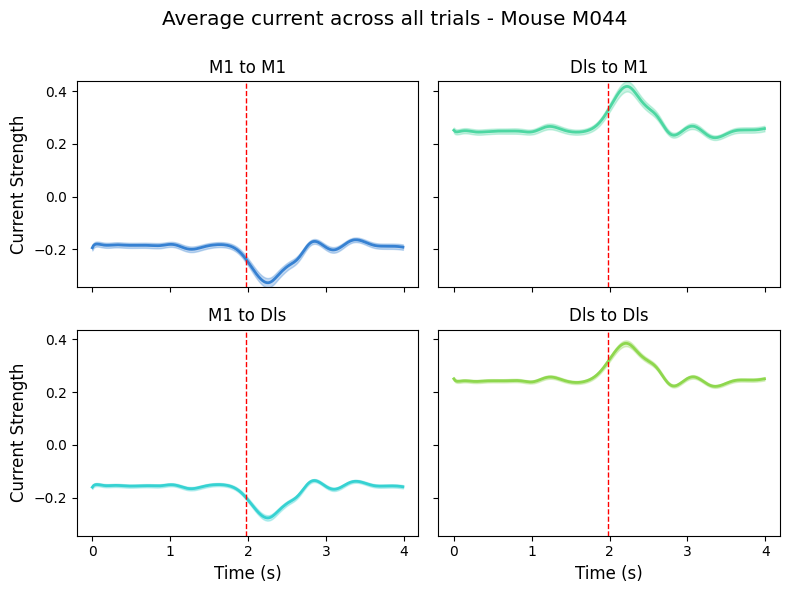

In [66]:
currents_fig = plot_currents_by_region(currents, current_labels, pyal_dict['perturbation_time_sec'], curbd_colors, BIN_SIZE, rnn_model['params']['dtFactor'], mouse)

In [ ]:
def plot_pca_currents(all_currents, all_currents_labels, perturbation_time, curbd_colors, mouse_num, fig_size = None):
    if fig_size != None:
        fig = pylab.figure(figsize=fig_size)
    else:
        fig = pylab.figure(figsize=(10, 8))
    
    count = 1
    n_regions = int(math.sqrt(len(all_currents)))
    colours = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

    for i in range(len(all_currents)):
        current_data = np.array(all_currents[i])
        current_label = all_currents_labels[i]
        colour = curbd_colors.get(current_label, colours[i % len(colours)])

        axn = fig.add_subplot(n_regions, n_regions, count, projection='3d')
        count += 1

        mean_current = np.mean(current_data, axis=1).T # keep neuron dimension, but mean across trials

        pca = PCA(n_components=min(mean_current.shape[0], mean_current.shape[1]))
        pca_current = pca.fit_transform(mean_current)

        axn.plot(pca_current[:, 0],
                 pca_current[:, 1],
                 pca_current[:, 2], color=colour)
        axn.scatter(
            pca_current[perturbation_time, 0],
            pca_current[perturbation_time, 1],
            pca_current[perturbation_time, 2],
            color='red',
            s=50,
            marker='o',
            label = "perturbation"
        )
        axn.scatter(
            pca_current[0, 0],
            pca_current[0, 1],
            pca_current[0, 2],
            color='black',
            s=60,
            marker='x',
            label = "trial start"
        )

        axn.xaxis.pane.fill = False
        axn.yaxis.pane.fill = False
        axn.zaxis.pane.fill = False
        
        # Remove axis ticks
        axn.set_xticks([])
        axn.set_yticks([])
        axn.set_zticks([])

        axn.set_title(f'{current_label} mean current', fontsize='x-large')
        axn.set_xlabel('PC1')
        axn.set_ylabel('PC2')
        axn.set_zlabel('PC3')
        axn.grid(False)
        # Collect handles and labels from the last axes (or choose one representative one)
        handles, labels = axn.get_legend_handles_labels()

        # Add a single legend outside the plot
        fig.legend(
            handles,
            labels,
            loc='center right',
            bbox_to_anchor=(1.05, 0.5)
        )

    fig.suptitle(f'PCA of average current across all trials - mouse {mouse_num}', fontsize='xx-large')
    fig.tight_layout()
    fig.show()

    return fig

/tmp/ipykernel_2722898/2694675066.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


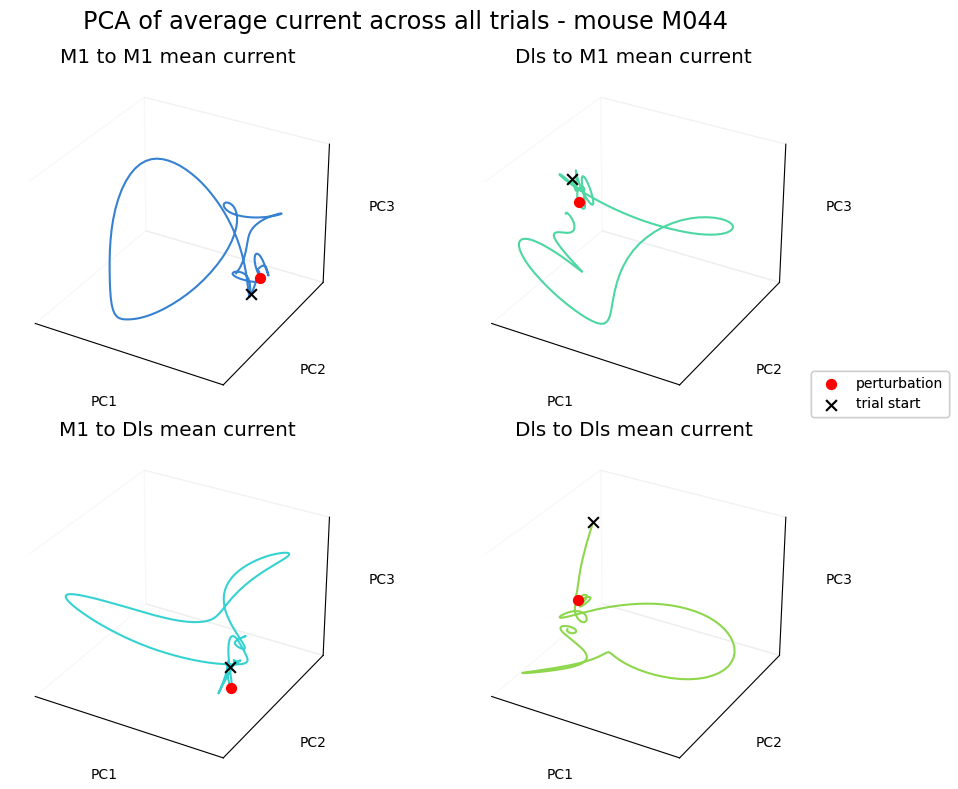

In [ ]:
pca_current_fig = plot_pca_currents(currents, current_labels, pyal_dict['perturbation_time'], curbd_colors, mouse)